# Librerie e Pacchetti

In [28]:
# Uncomment for any libraries that are not installed

# %pip install transformers
# %pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
# %pip install numpy scipy scikit-learn pandas matplotlib
# %pip install imblearn
# %pip install nltk
# %pip install tqdm
# %pip install groq
# %pip install seaborn

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement jupyterlab_mermaid (from versions: none)
ERROR: No matching distribution found for jupyterlab_mermaid


In [2]:
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from transformers import get_linear_schedule_with_warmup, pipeline
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import time
import datetime
from tqdm import tqdm
import os

c:\Users\alexc\anaconda3\envs\TorchP11\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

# Load the dataset
data_file = "train-balanced-sarcasm.csv"  # File must be in the same directory as this script
train_data = pd.read_csv(data_file)
train_data.head()

Using device: cuda


,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,0,NC and NH.,Trumpbart,politics,2,-1,-1,2016-10,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ..."
1,0,You do know west teams play against west teams...,Shbshb906,nba,-4,-1,-1,2016-11,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...
2,0,"They were underdogs earlier today, but since G...",Creepeth,nfl,3,3,0,2016-09,2016-09-22 21:45:37,They're favored to win.
3,0,"This meme isn't funny none of the ""new york ni...",icebrotha,BlackPeopleTwitter,-8,-1,-1,2016-10,2016-10-18 21:03:47,deadass don't kill my buzz
4,0,I could use one of those tools.,cush2push,MaddenUltimateTeam,6,-1,-1,2016-12,2016-12-30 17:00:13,Yep can confirm I saw the tool they use for th...


# Sentiment - Test con groq e HuggingFace

In [3]:
# # Groq Sentiment Analysis
# GROQ_API_KEY = os.environ.get('GROQ_API_KEY')
# if not GROQ_API_KEY:
#     raise ValueError("GROQ_API_KEY not found. Please set it as an environment variable.")

# client = Groq(api_key=GROQ_API_KEY)

# def preprocess_text(text):
#     return str(text) if pd.notna(text) else ""

# def parse_sentiment_response(response):
#     lines = response.strip().split('\n')
#     sentiment = None
#     confidence = None
#     for line in lines:
#         if line.startswith("Sentiment:"):
#             sentiment = line.split(":")[1].strip()
#         elif line.startswith("Confidence:"):
#             try:
#                 confidence = float(line.split(":")[1].strip())
#             except ValueError:
#                 print(f"Error parsing confidence: {line}")
#                 confidence = None
#     return sentiment, confidence

# def analyze_sentiment_groq(text):
#     try:
#         text = preprocess_text(text)
#         if not text:
#             return "NEUTRAL", 0.5

#         prompt = f"""Analyze the sentiment of the following text. Respond with only the sentiment (POSITIVE, NEGATIVE, or NEUTRAL) and a confidence score between 0 and 1.

# Text: "{text}"

# Format your response as:
# Sentiment: [SENTIMENT]
# Confidence: [SCORE]"""

#         chat_completion = client.chat.completions.create(
#             messages=[
#                 {
#                     "role": "user",
#                     "content": prompt,
#                 }
#             ],
#             model="llama3-8b-8192",
#             max_tokens=30
#         )

#         response = chat_completion.choices[0].message.content.strip()
#         sentiment, confidence = parse_sentiment_response(response)

#         if sentiment is None or confidence is None:
#             print(f"Error in analysis: {text}")
#             print(f"Response: {response}")
#             return "ERROR", 0.0

#         return sentiment, confidence
#     except Exception as e:
#         print(f"Error processing text: {text}")
#         print(f"Error message: {str(e)}")
#         return "ERROR", 0.0


In [3]:
# Hugging Face Sentiment Analysis
def preprocess_text(text):
    return str(text) if pd.notna(text) else ""

sentiment_pipeline = pipeline("sentiment-analysis", device=0 if torch.cuda.is_available() else -1)

def analyze_sentiment_huggingface(text):
    text = preprocess_text(text)
    if not text:
        return "NEUTRAL", 0.5
    
    result = sentiment_pipeline(text[:512])[0]  # Truncate to 512 tokens if longer
    sentiment = "POSITIVE" if result['label'] == "LABEL_1" else "NEGATIVE"
    confidence = result['score']
    
    return sentiment, confidence

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
c:\Users\alexc\anaconda3\envs\TorchP11\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [4]:
# Perform sentiment analysis on a sample of the data
sample_size = 1000  # Adjust as needed
train_data_sample = train_data.head(sample_size)
train_data_sample['comment'] = train_data_sample['comment'].apply(preprocess_text)

print("Performing sentiment analysis...")
tqdm.pandas(desc="Sentiment Analysis")
sentiment_results = train_data_sample['comment'].progress_apply(analyze_sentiment_huggingface)
train_data_sample['sentiment_label'], train_data_sample['sentiment_score'] = zip(*sentiment_results)

C:\Users\alexc\AppData\Local\Temp\ipykernel_42496\2240791432.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data_sample['comment'] = train_data_sample['comment'].apply(preprocess_text)


Performing sentiment analysis...


Sentiment Analysis: 100%|██████████| 1000/1000 [00:04<00:00, 218.44it/s]
C:\Users\alexc\AppData\Local\Temp\ipykernel_42496\2240791432.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data_sample['sentiment_label'], train_data_sample['sentiment_score'] = zip(*sentiment_results)
C:\Users\alexc\AppData\Local\Temp\ipykernel_42496\2240791432.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data_sample['sentiment_label'], train_data_sample['sentiment_score'] = zip(*sentiment_results)


In [5]:
# Save sentiment analysis results
train_data_sample[['label', 'comment', 'sentiment_label', 'sentiment_score']].to_csv('sentiment_analysis_results.csv', index=False)
print("Sentiment analysis results saved to 'sentiment_analysis_results.csv'")

Sentiment analysis results saved to 'sentiment_analysis_results.csv'


In [6]:
# Print sentiment analysis statistics
print("\nSentiment Distribution:")
print(train_data_sample['sentiment_label'].value_counts(normalize=True))
print("\nAverage Sentiment Score:", train_data_sample['sentiment_score'].mean())


Sentiment Distribution:
sentiment_label
NEGATIVE    0.999
NEUTRAL     0.001
Name: proportion, dtype: float64

Average Sentiment Score: 0.9585784313082695


# Sarcasm detection

## BERT

### General description

We have used a BERT (Bidirectional Encoder Representations from Transformers) model, specifically the "*bert-base-uncased*" variant, fine-tuned for sequence classification.
Key characteristics of this model include:

- **Architecture**: It's based on the original BERT architecture, which consists of 12 transformer layers, 12 attention heads, and 768 hidden dimensions.

- **Pre-training**: This model was pre-trained on a large corpus of uncased English text (meaning it treats "The" and "the" as the same token). The pre-training tasks typically include masked language modeling and next sentence prediction, which help the model learn general language understanding.

- **Fine-tuning**: We've fine-tuned this pre-trained model for our specific task of sarcasm detection. This involves adding a classification layer on top of the BERT base and training on our sarcasm dataset.

- **Tokenizer**: It uses the BERT tokenizer, which employs WordPiece tokenization.

- **Sequence Classification**: The model is set up for sequence classification, where it takes in a sequence of tokens (in our case, a Reddit comment) and outputs a classification (sarcastic or not sarcastic).

- **Uncased**: As mentioned, this version is uncased, meaning it doesn't differentiate between uppercase and lowercase letters. This can be beneficial for tasks where case doesn't carry significant meaning, potentially reducing the vocabulary size and model complexity.

- **Size**: The "base" in "bert-base-uncased" indicates that this is the smaller version of BERT (as opposed to "bert-large"), with about 110 million parameters.

This model is well-suited for our task because it has been pre-trained on a large amount of text data, allowing it to capture complex language patterns that can be crucial for detecting sarcasm. The fine-tuning process then adapts this general language understanding to our specific task of sarcasm detection.


### Tokenization process

The tokenization process in this project was performed using the BERT tokenizer, specifically the one associated with the 'bert-base-uncased' model. Here's a brief description of how it works:

#### Tokenizer Initialization:
The tokenizer is initialized using the BertTokenizer.from_pretrained('bert-base-uncased') method. This loads the pre-trained tokenizer that matches the BERT model we're using.
The 'uncased' version of the tokenizer converts all text to lowercase before tokenization. BERT uses WordPiece tokenization, which breaks words into subwords. This helps handle out-of-vocabulary words and reduces the overall vocabulary size. For example, "tokenization" might be broken into "token" and "##ization".

#### Special Tokens:
The tokenizer adds special tokens:

[CLS] at the beginning of each sequence (used for classification tasks)
[SEP] at the end of each sequence (or between sequences for pair tasks)

#### Encoding:
The tokenization process encodes each comment using the encode_plus method, which tokenizes the text, converts tokens to their respective IDs, adds special tokens, and generates attention masks (1 for real tokens, 0 for padding).

#### Padding and Truncation:
Sequences are padded to a maximum length (MAX_LEN = 128 in this case) with a padding token (usually [PAD]).
If a sequence is longer than MAX_LEN, it's truncated.

#### Tensors Creation:
The tokenized and encoded data is converted into PyTorch tensors for input to the model.

This process was applied to both the training and testing datasets, ensuring that the text input is in a format that the BERT model can process. The use of subword tokenization and special tokens allows the model to handle a wide variety of inputs, including words it hasn't seen during pre-training.

In [4]:
# BERT Model training for sarcasm detection
num_examples = 100000
comments = train_data[:num_examples].dropna().comment.values
labels = train_data[:num_examples].dropna().label.values

In [9]:
# Initialize BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# Load pre-trained BERT model
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=2,
    output_attentions=False,
    output_hidden_states=False,
)

# Move the model to the appropriate device (CPU or GPU)
model.to(device)

# Tokenize and encode the dataset
MAX_LEN = 128

input_ids = []
attention_masks = []

for comment in comments:
    encoded_dict = tokenizer.encode_plus(
        comment,
        add_special_tokens=True,
        max_length=MAX_LEN,
        padding='max_length',
        return_attention_mask=True,
        return_tensors='pt',
        truncation=True
    )
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Pl

In [10]:
# Create DataLoader
dataset = TensorDataset(input_ids, attention_masks, labels)
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

batch_size = 32

train_dataloader = DataLoader(
    train_dataset,
    sampler=torch.utils.data.RandomSampler(train_dataset),
    batch_size=batch_size
)

validation_dataloader = DataLoader(
    val_dataset,
    sampler=torch.utils.data.SequentialSampler(val_dataset),
    batch_size=batch_size
)

In [11]:
# Set up optimizer and learning rate scheduler
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)

epochs = 5
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=0,
                                            num_training_steps=total_steps)

c:\Users\alexc\anaconda3\envs\TorchP11\Lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [27]:
# Training loop for BERT model

def format_time(seconds):
    return str(datetime.timedelta(seconds=int(seconds)))

def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

# Training loop
total_t0 = time.time()
total_train_loss = 0
total_val_loss = 0
total_val_accuracy = 0

for epoch in range(epochs):
    print(f'\nEpoch {epoch+1}/{epochs}')
    epoch_t0 = time.time()
    
    # Training
    model.train()
    total_train_loss = 0
    
    progress_bar = tqdm(enumerate(train_dataloader), total=len(train_dataloader), 
                        desc="Training", unit="batch")
    
    for step, batch in progress_bar:
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        
        loss = outputs.loss
        total_train_loss += loss.item()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

        # Update progress bar
        elapsed = format_time(time.time() - epoch_t0)
        elapsed_total = format_time(time.time() - total_t0)
        
        progress_bar.set_postfix({
            'Loss': f'{loss.item():.4f}',
            'Epoch Elapsed': elapsed,
            'Total Elapsed': elapsed_total,
            'Epoch Remaining': format_time((time.time() - epoch_t0) / (step + 1) * (len(train_dataloader) - step - 1)),
            'Total Remaining': format_time((time.time() - total_t0) / ((epoch * len(train_dataloader) + step + 1)) * (epochs * len(train_dataloader) - (epoch * len(train_dataloader) + step + 1)))
        })

    avg_train_loss = total_train_loss / len(train_dataloader)

    # Validation
    model.eval()
    total_eval_accuracy = 0
    total_eval_loss = 0

    for batch in validation_dataloader:
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        with torch.no_grad():        
            outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        
        loss = outputs.loss
        logits = outputs.logits
        
        total_eval_loss += loss.item()
        total_eval_accuracy += flat_accuracy(logits.detach().cpu().numpy(), b_labels.to('cpu').numpy())

    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    avg_val_loss = total_eval_loss / len(validation_dataloader)

    # Print epoch results
    print(f"\nEpoch {epoch+1} Results:")
    print(f"  Training Loss: {avg_train_loss:.4f}")
    print(f"  Validation Loss: {avg_val_loss:.4f}")
    print(f"  Validation Accuracy: {avg_val_accuracy:.4f}")
    print(f"  Epoch Time: {format_time(time.time() - epoch_t0)}")
    print(f"  Total Time: {format_time(time.time() - total_t0)}")

print("\nTraining complete!")
print(f"Total training took {format_time(time.time()-total_t0)}")


Epoch 1/5


Training: 100%|██████████| 2813/2813 [06:28<00:00,  7.25batch/s, Loss=0.0141, Epoch Elapsed=0:06:28, Total Elapsed=0:06:28, Epoch Remaining=0:00:00, Total Remaining=0:25:53]



Epoch 1 Results:
  Training Loss: 0.1326
  Validation Loss: 0.8939
  Validation Accuracy: 0.7389
  Epoch Time: 0:06:40
  Total Time: 0:06:40

Epoch 2/5


Training: 100%|██████████| 2813/2813 [06:31<00:00,  7.19batch/s, Loss=0.0168, Epoch Elapsed=0:06:31, Total Elapsed=0:13:12, Epoch Remaining=0:00:00, Total Remaining=0:19:48]



Epoch 2 Results:
  Training Loss: 0.1317
  Validation Loss: 0.8939
  Validation Accuracy: 0.7389
  Epoch Time: 0:06:44
  Total Time: 0:13:24

Epoch 3/5


Training: 100%|██████████| 2813/2813 [06:29<00:00,  7.23batch/s, Loss=0.4580, Epoch Elapsed=0:06:29, Total Elapsed=0:19:54, Epoch Remaining=0:00:00, Total Remaining=0:13:16]



Epoch 3 Results:
  Training Loss: 0.1314
  Validation Loss: 0.8939
  Validation Accuracy: 0.7389
  Epoch Time: 0:06:42
  Total Time: 0:20:06

Epoch 4/5


Training: 100%|██████████| 2813/2813 [06:24<00:00,  7.32batch/s, Loss=0.0650, Epoch Elapsed=0:06:24, Total Elapsed=0:26:31, Epoch Remaining=0:00:00, Total Remaining=0:06:37]



Epoch 4 Results:
  Training Loss: 0.1333
  Validation Loss: 0.8939
  Validation Accuracy: 0.7389
  Epoch Time: 0:06:36
  Total Time: 0:26:43

Epoch 5/5


Training: 100%|██████████| 2813/2813 [06:37<00:00,  7.08batch/s, Loss=0.0330, Epoch Elapsed=0:06:37, Total Elapsed=0:33:21, Epoch Remaining=0:00:00, Total Remaining=0:00:00]



Epoch 5 Results:
  Training Loss: 0.1332
  Validation Loss: 0.8939
  Validation Accuracy: 0.7389
  Epoch Time: 0:06:50
  Total Time: 0:33:33

Training complete!
Total training took 0:33:33


In [29]:
# Save the entire model (including tokenizer)
output_dir = './bert_sarcasm_model2/'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print(f"Saving model to {output_dir}")
model_to_save = model.module if hasattr(model, 'module') else model
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

print("Model and tokenizer saved!")

Saving model to ./bert_sarcasm_model2/
Model and tokenizer saved!


In [30]:
import torch
from transformers import BertForSequenceClassification, BertTokenizer
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the saved model and tokenizer
model_path = './bert_sarcasm_model2/'
model = BertForSequenceClassification.from_pretrained(model_path)
tokenizer = BertTokenizer.from_pretrained(model_path)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

def predict_sarcasm(text):
    # Tokenize and encode the text
    encoded_dict = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=128,
        padding='max_length',
        return_attention_mask=True,
        return_tensors='pt',
        truncation=True
    )
    
    input_ids = encoded_dict['input_ids'].to(device)
    attention_mask = encoded_dict['attention_mask'].to(device)
    
    # Perform inference
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
    
    # Get prediction
    prediction = torch.argmax(logits, dim=1).item()
    probability = torch.nn.functional.softmax(logits, dim=1)[0][prediction].item()
    
    return "Sarcastic" if prediction == 1 else "Not sarcastic", probability

In [31]:
# Test the model with some example texts
example_texts = [
    "I absolutely love waiting in long lines at the DMV.",
    "The weather is beautiful today.",
    "Wow, getting a root canal is so much fun!",
    "I'm excited about the new movie coming out.",
    "This is the best day ever! My car broke down and I lost my wallet.",
    "Oh, great, another update that 'improves' the app by making it crash even more. Thanks, developers!",
    "Sure, because spending an entire day in line at the DMV is exactly how I wanted to spend my Saturday.",
    "Wow, this 50-page instruction manual for a simple coffee maker is exactly what I needed. So intuitive!",
    "Of course, I love when my internet cuts out right in the middle of a critical work meeting. Who doesn't?",
    "Yeah, because nothing says 'professionalism' like sending an email in Comic Sans.",
    "I think this new feature will be really useful for organizing my projects.",
    "Thanks for the suggestion! I'll definitely check out that book.",
    "I completely agree with you, the new season of the show is much better than the last one.",
    "That recipe turned out great! Thanks for sharing it with us.",
    "I had a great experience with their customer service, they were really helpful and responsive."
]

print("Predicting sarcasm for example texts:")
for text in example_texts:
    prediction, probability = predict_sarcasm(text)
    print(f"Text: {text}")
    print(f"Prediction: {prediction} (Probability: {probability:.2f})")
    print()

Predicting sarcasm for example texts:
Text: I absolutely love waiting in long lines at the DMV.
Prediction: Sarcastic (Probability: 0.77)

Text: The weather is beautiful today.
Prediction: Sarcastic (Probability: 0.73)

Text: Wow, getting a root canal is so much fun!
Prediction: Sarcastic (Probability: 0.98)

Text: I'm excited about the new movie coming out.
Prediction: Sarcastic (Probability: 0.95)

Text: This is the best day ever! My car broke down and I lost my wallet.
Prediction: Not sarcastic (Probability: 0.99)

Text: Oh, great, another update that 'improves' the app by making it crash even more. Thanks, developers!
Prediction: Sarcastic (Probability: 1.00)

Text: Sure, because spending an entire day in line at the DMV is exactly how I wanted to spend my Saturday.
Prediction: Sarcastic (Probability: 0.98)

Text: Wow, this 50-page instruction manual for a simple coffee maker is exactly what I needed. So intuitive!
Prediction: Sarcastic (Probability: 1.00)

Text: Of course, I love 

In [32]:
# Load and evaluate on test dataset
test_data = pd.read_csv("test_sarcasm.csv")

def prepare_data(data):
    input_ids = []
    attention_masks = []
    
    for comment in data['comment']:
        encoded_dict = tokenizer.encode_plus(
            comment,
            add_special_tokens=True,
            max_length=128,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])
    
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    
    return input_ids, attention_masks

input_ids, attention_masks = prepare_data(test_data)
labels = torch.tensor(test_data['label'].values)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
c:\Users\alexc\anaconda3\envs\TorchP11\Lib\site-packages\transformers\tokenization_utils_base.py:2870: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [33]:
# Create the DataLoader
test_dataset = TensorDataset(input_ids, attention_masks, labels)
test_dataloader = DataLoader(test_dataset, batch_size=32)

# Evaluation
predictions = []
true_labels = []

In [34]:
for batch in test_dataloader:
    b_input_ids = batch[0].to(device)
    b_attention_mask = batch[1].to(device)
    b_labels = batch[2].to(device)
    
    with torch.no_grad():
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_attention_mask)
    
    logits = outputs[0]
    batch_predictions = torch.argmax(logits, dim=1).flatten()
    
    predictions.extend(batch_predictions.cpu().numpy())
    true_labels.extend(b_labels.cpu().numpy())

In [35]:
# Calculate metrics
accuracy = accuracy_score(true_labels, predictions)
precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predictions, average='binary')

print("Model Performance on Test Set:")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

Model Performance on Test Set:
Accuracy: 0.76
Precision: 0.77
Recall: 0.74
F1 Score: 0.76


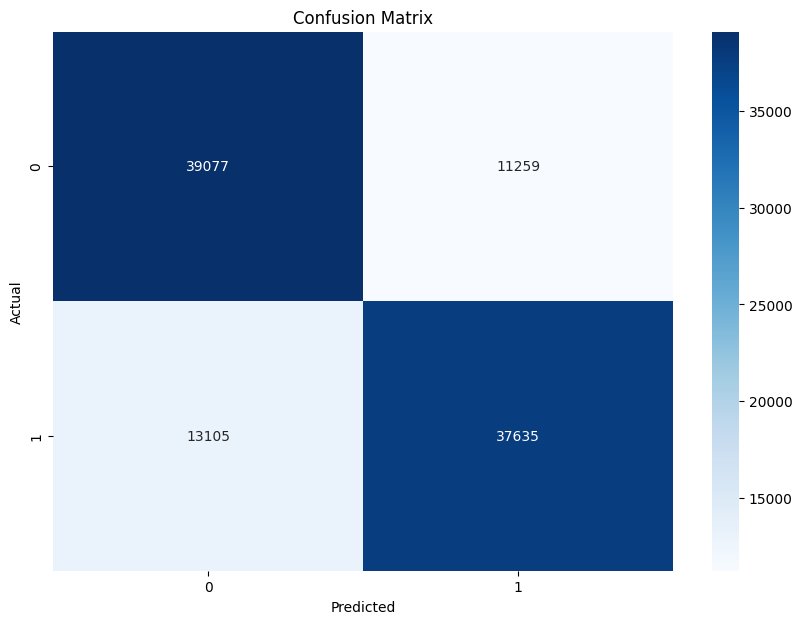

In [36]:
# Confusion Matrix
cm = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

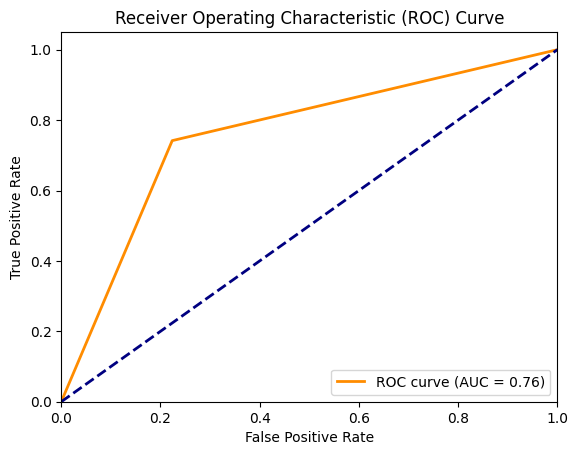

In [37]:
# ROC Curve
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(true_labels, predictions)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [18]:
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split
from transformers import RobertaTokenizer, RobertaForSequenceClassification, AdamW
from transformers import get_linear_schedule_with_warmup
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import time
import datetime
from tqdm import tqdm, trange
import os

In [ ]:
from transformers import RobertaTokenizer, RobertaForSequenceClassification, AdamW

# Initialize RoBERTa tokenizer
tokenizer = RobertaTokenizer.from_pretrained('roberta-base', do_lower_case=True)

# Load pre-trained RoBERTa model
model = RobertaForSequenceClassification.from_pretrained(
    "roberta-base",
    num_labels=2,
    output_attentions=False,
    output_hidden_states=False,
)

model.to(device)

In [21]:
# Training loop FOR ROBERTA
def format_time(elapsed):
    return str(datetime.timedelta(seconds=int(round(elapsed))))

def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

total_t0 = time.time()

for epoch_i in trange(0, epochs, desc="Epochs"):
    print(f'\n======== Epoch {epoch_i + 1} / {epochs} ========')
    print('Training...')

    t0 = time.time()
    total_train_loss = 0
    model.train()

    progress_bar = tqdm(train_dataloader, desc="Training", leave=False)
    for step, batch in enumerate(progress_bar):
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()        

        outputs = model(b_input_ids, 
                        attention_mask=b_input_mask, 
                        labels=b_labels)
        
        loss = outputs.loss
        total_train_loss += loss.item()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

        progress_bar.set_postfix({'loss': f'{loss.item():.3f}'})

    avg_train_loss = total_train_loss / len(train_dataloader)            
    training_time = format_time(time.time() - t0)

    print(f"\n  Average training loss: {avg_train_loss:.2f}")
    print(f"  Training epoch took: {training_time}")
        
    print("\nRunning Validation...")

    t0 = time.time()
    model.eval()

    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    for batch in tqdm(validation_dataloader, desc="Validation", leave=False):
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        with torch.no_grad():        
            outputs = model(b_input_ids, 
                            attention_mask=b_input_mask,
                            labels=b_labels)
            
        loss = outputs.loss
        logits = outputs.logits
        
        total_eval_loss += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print(f"  Accuracy: {avg_val_accuracy:.2f}")

    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    validation_time = format_time(time.time() - t0)
    
    print(f"  Validation Loss: {avg_val_loss:.2f}")
    print(f"  Validation took: {validation_time}")

print("")
print("Training complete!")
print(f"Total training took {format_time(time.time()-total_t0)}")

Epochs:   0%|          | 0/5 [00:00<?, ?it/s]


======== Epoch 1 / 5 ========
Training...



  Average training loss: 0.55
  Training epoch took: 0:06:59

Running Validation...


Epochs:  20%|██        | 1/5 [07:12<28:51, 432.76s/it]

  Accuracy: 0.76
  Validation Loss: 0.51
  Validation took: 0:00:13

======== Epoch 2 / 5 ========
Training...



  Average training loss: 0.47
  Training epoch took: 0:06:58

Running Validation...


Epochs:  40%|████      | 2/5 [14:24<21:36, 432.18s/it]

  Accuracy: 0.76
  Validation Loss: 0.50
  Validation took: 0:00:13

======== Epoch 3 / 5 ========
Training...



  Average training loss: 0.40
  Training epoch took: 0:07:00

Running Validation...


Epochs:  60%|██████    | 3/5 [21:37<14:25, 432.62s/it]

  Accuracy: 0.76
  Validation Loss: 0.55
  Validation took: 0:00:13

======== Epoch 4 / 5 ========
Training...



  Average training loss: 0.33
  Training epoch took: 0:07:07

Running Validation...


Epochs:  80%|████████  | 4/5 [28:58<07:15, 435.70s/it]

  Accuracy: 0.76
  Validation Loss: 0.59
  Validation took: 0:00:14

======== Epoch 5 / 5 ========
Training...



  Average training loss: 0.28
  Training epoch took: 0:07:05

Running Validation...


Epochs: 100%|██████████| 5/5 [36:16<00:00, 435.39s/it]

  Accuracy: 0.76
  Validation Loss: 0.66
  Validation took: 0:00:14

Training complete!
Total training took 0:36:17


In [22]:
# Save the entire model (including tokenizer)
output_dir = './roberta_sarcasm_model/'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print(f"Saving model to {output_dir}")
model_to_save = model.module if hasattr(model, 'module') else model
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

print("Model and tokenizer saved!")

Saving model to ./roberta_sarcasm_model/
Model and tokenizer saved!


In [24]:
import torch
from transformers import RobertaForSequenceClassification, RobertaTokenizer
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, roc_curve, auc
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

# Load the saved model and tokenizer
model_dir = './roberta_sarcasm_model/'
model = RobertaForSequenceClassification.from_pretrained(model_dir)
tokenizer = RobertaTokenizer.from_pretrained(model_dir)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

def predict_sarcasm(text):
    encoded_dict = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=128,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt',
    )
    input_ids = encoded_dict['input_ids'].to(device)
    attention_mask = encoded_dict['attention_mask'].to(device)
    
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
    
    logits = outputs.logits
    probabilities = torch.nn.functional.softmax(logits, dim=1)
    prediction = torch.argmax(probabilities, dim=1).item()
    probability = probabilities[0][prediction].item()
    
    return "Sarcastic" if prediction == 1 else "Not sarcastic", probability

In [25]:
# Test with individual texts
test_texts = [
    "I absolutely love waiting in long lines at the DMV.",
    "The weather is beautiful today.",
    "Wow, getting a root canal is my favorite way to spend an afternoon!",
    "I'm excited about the new movie coming out next week."
]

print("Testing individual texts:")
for text in test_texts:
    prediction, probability = predict_sarcasm(text)
    print(f"Text: {text}")
    print(f"Prediction: {prediction}")
    print(f"Confidence: {probability:.2f}")
    print()


Testing individual texts:
Text: I absolutely love waiting in long lines at the DMV.
Prediction: Sarcastic
Confidence: 0.99

Text: The weather is beautiful today.
Prediction: Not sarcastic
Confidence: 0.77

Text: Wow, getting a root canal is my favorite way to spend an afternoon!
Prediction: Sarcastic
Confidence: 0.91

Text: I'm excited about the new movie coming out next week.
Prediction: Sarcastic
Confidence: 0.98



In [26]:
# Load and evaluate on test dataset
print("Evaluating on test dataset...")
test_data = pd.read_csv("test_sarcasm.csv")

def prepare_data(data):
    input_ids = []
    attention_masks = []
    
    for comment in tqdm(data['comment'], desc="Preprocessing"):
        encoded_dict = tokenizer.encode_plus(
            comment,
            add_special_tokens=True,
            max_length=128,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])
    
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    
    return input_ids, attention_masks

input_ids, attention_masks = prepare_data(test_data)
labels = torch.tensor(test_data['label'].values)

# Create the DataLoader
test_dataset = TensorDataset(input_ids, attention_masks, labels)
test_dataloader = DataLoader(test_dataset, batch_size=32)

# Evaluation
predictions = []
true_labels = []
prediction_probs = []

for batch in tqdm(test_dataloader, desc="Evaluating"):
    b_input_ids = batch[0].to(device)
    b_attention_mask = batch[1].to(device)
    b_labels = batch[2].to(device)
    
    with torch.no_grad():
        outputs = model(b_input_ids, attention_mask=b_attention_mask)
    
    logits = outputs.logits
    probabilities = torch.nn.functional.softmax(logits, dim=1)
    batch_predictions = torch.argmax(probabilities, dim=1).flatten()
    
    predictions.extend(batch_predictions.cpu().numpy())
    true_labels.extend(b_labels.cpu().numpy())
    prediction_probs.extend(probabilities[:, 1].cpu().numpy())

Evaluating on test dataset...


Evaluating: 100%|██████████| 3159/3159 [02:16<00:00, 23.12it/s]


In [27]:
# Calculate metrics
accuracy = accuracy_score(true_labels, predictions)
precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predictions, average='binary')

print("\nModel Performance on Test Set:")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")


Model Performance on Test Set:
Accuracy: 0.77
Precision: 0.79
Recall: 0.73
F1 Score: 0.76


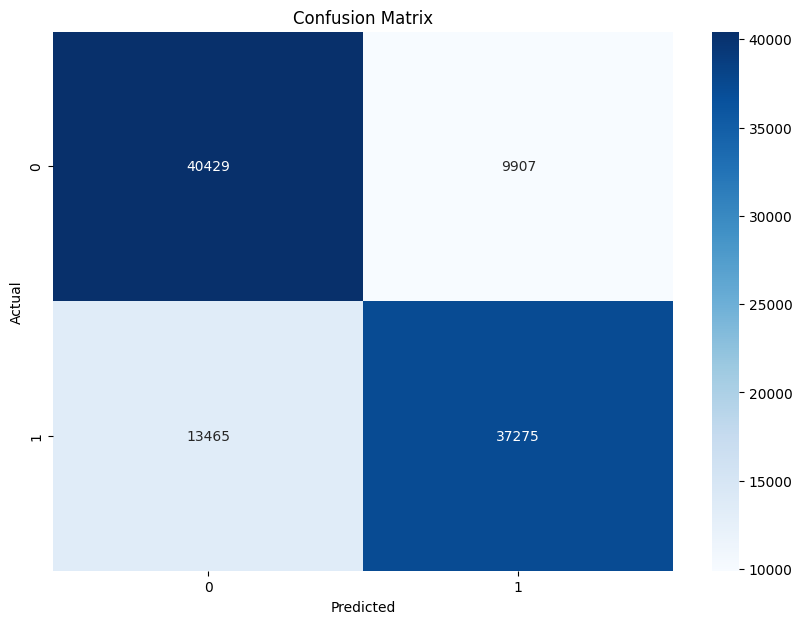

In [28]:
# Confusion Matrix
cm = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

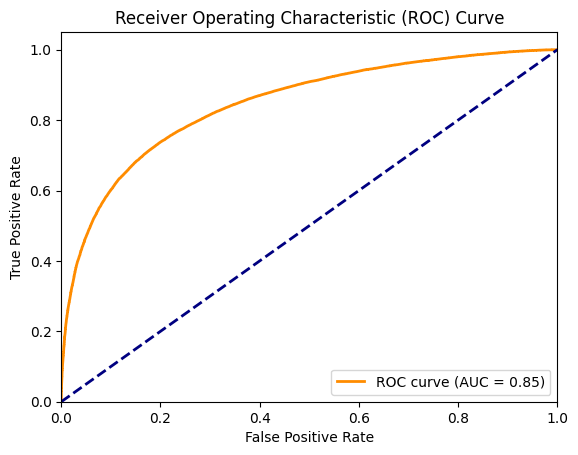

In [29]:
# ROC Curve
fpr, tpr, _ = roc_curve(true_labels, prediction_probs)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

#Configurazione GPU/CPU

In [ ]:
# # Get the GPU device name.
# device_name = tf.test.gpu_device_name()

# # The device name should look like the following:
# if device_name == '/device:GPU:0':
#     print('Found GPU at: {}'.format(device_name))

# # If there's a GPU available...
# if torch.cuda.is_available():

#     # Tell PyTorch to use the GPU.
#     device = torch.device("cuda")

#     print('There are %d GPU(s) available.' % torch.cuda.device_count())

#     print('We will use the GPU:', torch.cuda.get_device_name(0))

# # If not...
# else:
#     print('No GPU available, using the CPU instead.')
#     device = torch.device("cpu")

No GPU available, using the CPU instead.


# Scelta del Modello

In [7]:
class ModelChoice(Enum):
    BERT = 1
    DISTILBERT = 2
    ALBERT = 3
    ELECTRA = 4

MODEL_CHOICE = ModelChoice.DISTILBERT    #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


print('Loading tokenizer...')
if MODEL_CHOICE == ModelChoice.BERT:
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
elif MODEL_CHOICE == ModelChoice.DISTILBERT:
    tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased', do_lower_case=True)
elif MODEL_CHOICE == ModelChoice.ALBERT:
    tokenizer =  AlbertTokenizer.from_pretrained('albert-base-v2', do_lower_case=True)
elif MODEL_CHOICE == ModelChoice.ELECTRA:
    tokenizer = ElectraTokenizer.from_pretrained("google/electra-base-discriminator", do_lower_case=True)
else:
    print("Choose proper model!")


NameError: name 'Enum' is not defined

#Test sul Sentimento

In [ ]:
!pip install groq

import os
import pandas as pd
from groq import Groq
from tqdm import tqdm
from google.colab import userdata

# Ottieni la chiave API di Groq dall'ambiente di Colab
GROQ_API_KEY = userdata.get('GROQ_API_KEY')

# Verifica se la chiave API è stata impostata correttamente
if not GROQ_API_KEY:
    raise ValueError("GROQ_API_KEY non trovata. Assicurati di averla impostata nelle variabili segrete di Colab.")

# Inizializza il client Groq
client = Groq(api_key=GROQ_API_KEY)

def preprocess_text(text):
    if pd.isna(text):
        return ""
    return str(text)

def parse_sentiment_response(response):
    lines = response.strip().split('\n')
    sentiment = None
    confidence = None
    for line in lines:
        if line.startswith("Sentiment:"):
            sentiment = line.split(":")[1].strip()
        elif line.startswith("Confidence:"):
            try:
                confidence = float(line.split(":")[1].strip())
            except ValueError:
                print(f"Errore nel parsing della confidenza: {line}")
                confidence = None
    return sentiment, confidence

def analyze_sentiment_groq(text):
    try:
        text = preprocess_text(text)
        if not text:
            return "NEUTRAL", 0.5

        prompt = f"""Analyze the sentiment of the following text. Respond with only the sentiment (POSITIVE, NEGATIVE, or NEUTRAL) and a confidence score between 0 and 1.

Text: "{text}"

Format your response as:
Sentiment: [SENTIMENT]
Confidence: [SCORE]"""

        chat_completion = client.chat.completions.create(
            messages=[
                {
                    "role": "user",
                    "content": prompt,
                }
            ],
            model="llama3-8b-8192",
            max_tokens=30
        )

        response = chat_completion.choices[0].message.content.strip()
        sentiment, confidence = parse_sentiment_response(response)

        if sentiment is None or confidence is None:
            print(f"Errore nell'analisi: {text}")
            print(f"Risposta: {response}")
            return "ERROR", 0.0

        return sentiment, confidence
    except Exception as e:
        print(f"Errore nell'elaborazione del testo: {text}")
        print(f"Messaggio di errore: {str(e)}")
        return "ERROR", 0.0


train_data = train_data.head(100)
# Applica l'analisi del sentimento al dataset
print("Esecuzione dell'analisi del sentimento...")
train_data['comment'] = train_data['comment'].apply(preprocess_text)

# Usa tqdm per creare una barra di avanzamento
tqdm.pandas(desc="Analisi dei sentimenti")
sentiment_results = train_data['comment'].progress_apply(analyze_sentiment_groq)
train_data['sentiment_label'], train_data['sentiment_score'] = zip(*sentiment_results)

# Crea il dataframe di output con solo le colonne richieste
output_data = train_data[['label', 'comment', 'sentiment_label', 'sentiment_score']]

# Salva i risultati
output_filename = 'reddit_sentiment_analysis_results_groq.csv'
output_data.to_csv(output_filename, index=False)
print(f"Risultati salvati in '{output_filename}'")

# Mostra un campione dei risultati
print("\nCampione dei risultati:")
print(output_data.head())

# Alcune statistiche di base
print("\nDistribuzione delle etichette originali:")
print(output_data['label'].value_counts(normalize=True))

print("\nDistribuzione delle etichette di sentimento:")
print(output_data['sentiment_label'].value_counts(normalize=True))

print("\nPunteggio medio del sentimento:")
print(output_data['sentiment_score'].mean())

# Controlla eventuali errori nell'analisi del sentimento
error_count = (output_data['sentiment_label'] == 'ERROR').sum()
print(f"\nNumero di errori nell'analisi del sentimento: {error_count}")

<ipython-input-7-318fdeee4dab>:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['comment'] = train_data['comment'].apply(preprocess_text)


Esecuzione dell'analisi del sentimento...


Analisi dei sentimenti: 100%|██████████| 100/100 [03:11<00:00,  1.91s/it]

Risultati salvati in 'reddit_sentiment_analysis_results_groq.csv'

Campione dei risultati:
   label                                            comment sentiment_label  \
0      0                                         NC and NH.         NEUTRAL   
1      0  You do know west teams play against west teams...         NEUTRAL   
2      0  They were underdogs earlier today, but since G...        POSITIVE   
3      0  This meme isn't funny none of the "new york ni...        NEGATIVE   
4      0                    I could use one of those tools.         NEUTRAL   

   sentiment_score  
0             0.90  
1             0.90  
2             0.80  
3             0.95  
4             0.80  

Distribuzione delle etichette originali:
label
0    0.93
1    0.07
Name: proportion, dtype: float64

Distribuzione delle etichette di sentimento:
sentiment_label
NEGATIVE    0.45
NEUTRAL     0.36
POSITIVE    0.19
Name: proportion, dtype: float64

Punteggio medio del sentimento:
0.7989999999999999

Numero d

# Analisi del Dataset

In [ ]:
print("Number of training examples {}".format(len(train_data)))
num_examples = 100000
train = train_data[:num_examples].dropna().comment.values
labels = train_data[:num_examples].dropna().label.values

Number of training examples 1010826


In [ ]:
# Print the original sentence.
print(' Original: ', train[10])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(train[10]))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(train[10])))

 Original:  I think a significant amount would be against spending their tax dollars on other people.
Tokenized:  ['i', 'think', 'a', 'significant', 'amount', 'would', 'be', 'against', 'spending', 'their', 'tax', 'dollars', 'on', 'other', 'people', '.']
Token IDs:  [1045, 2228, 1037, 3278, 3815, 2052, 2022, 2114, 5938, 2037, 4171, 6363, 2006, 2060, 2111, 1012]


# Preprocessing del Dataset



In [ ]:
# Filtra i NaN
comment_lengths = train_data.comment.dropna().apply(lambda x: len(x))

# Calcola il 90° percentile
print(comment_lengths.quantile(0.9))
MAX_LEN = 109


109.0


In [ ]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for comment in train:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        comment,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = MAX_LEN,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )

    # Add the encoded sentence to the list.
    input_ids.append(encoded_dict['input_ids'])

    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Print sentence 0, now as a list of IDs.
print('Original: ', train[10])
print('Token IDs:', input_ids[10])


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Original:  I think a significant amount would be against spending their tax dollars on other people.
Token IDs: tensor([ 101, 1045, 2228, 1037, 3278, 3815, 2052, 2022, 2114, 5938, 2037, 4171,
        6363, 2006, 2060, 2111, 1012,  102,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0])


In [ ]:
#training & validation split
from torch.utils.data import TensorDataset, random_split


# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)

# Create a 90-10 train-validation split.

# Calculate the number of samples to include in each set.
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{} training samples'.format(train_size))
print('{} validation samples'.format(val_size))

89997 training samples
10000 validation samples


In [ ]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))

    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

# Set the seed value all over the place to make this reproducible.
import random
def set_random(seed_val):
    random.seed(seed_val)
    np.random.seed(seed_val)
    torch.manual_seed(seed_val)
    torch.cuda.manual_seed_all(seed_val)

# Train

In [ ]:
def train_model(train_dataloader, optimizer, epochs):

    # We'll store a number of quantities such as training and validation loss,
    # validation accuracy, and timings.
    training_stats = []

    # Measure the total training time for the whole run.
    total_t0 = time.time()

    # For each epoch...
    for epoch_i in range(0, epochs):

        # ========================================
        #               Training
        # ========================================

        # Perform one full pass over the training set.

        print("")
        print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
        print('Training...')

        # Measure how long the training epoch takes.
        t0 = time.time()

        # Reset the total loss for this epoch.
        total_train_loss = 0

        # Put the model into training mode. Don't be mislead--the call to
        # `train` just changes the *mode*, it doesn't *perform* the training.
        # `dropout` and `batchnorm` layers behave differently during training
        # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
        model.train()

        # For each batch of training data...
        for step, batch in enumerate(train_dataloader):

            # Progress update every 40 batches.
            if step % 40 == 0 and not step == 0:
                # Calculate elapsed time in minutes.
                elapsed = format_time(time.time() - t0)

                # Report progress.
                print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

            # Unpack this training batch from our dataloader.
            #
            # As we unpack the batch, we'll also copy each tensor to the GPU using the
            # `to` method.
            #
            # `batch` contains three pytorch tensors:
            #   [0]: input ids
            #   [1]: attention masks
            #   [2]: labels
            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)

            # Always clear any previously calculated gradients before performing a
            # backward pass. PyTorch doesn't do this automatically because
            # accumulating the gradients is "convenient while training RNNs".
            # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
            model.zero_grad()

            # Perform a forward pass (evaluate the model on this training batch).
            # The documentation for this `model` function is here:
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            # It returns different numbers of parameters depending on what arguments
            # arge given and what flags are set. For our useage here, it returns
            # the loss (because we provided labels) and the "logits"--the model
            # outputs prior to activation.
            loss, logits = model(b_input_ids,
                                 attention_mask=b_input_mask,
                                 labels=b_labels)

            # Accumulate the training loss over all of the batches so that we can
            # calculate the average loss at the end. `loss` is a Tensor containing a
            # single value; the `.item()` function just returns the Python value
            # from the tensor.
            total_train_loss += loss.item()

            # Perform a backward pass to calculate the gradients.
            loss.backward()

            # Clip the norm of the gradients to 1.0.
            # This is to help prevent the "exploding gradients" problem.
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update parameters and take a step using the computed gradient.
            # The optimizer dictates the "update rule"--how the parameters are
            # modified based on their gradients, the learning rate, etc.
            optimizer.step()

            # Update the learning rate.
            scheduler.step()

        # Calculate the average loss over all of the batches.
        avg_train_loss = total_train_loss / len(train_dataloader)

        # Measure how long this epoch took.
        training_time = format_time(time.time() - t0)

        print("")
        print("  Average training loss: {0:.2f}".format(avg_train_loss))
        print("  Training epcoh took: {:}".format(training_time))

        # ========================================
        #               Validation
        # ========================================
        # After the completion of each training epoch, measure our performance on
        # our validation set.

        print("")
        print("Running Validation...")

        t0 = time.time()

        # Put the model in evaluation mode--the dropout layers behave differently
        # during evaluation.
        model.eval()

        # Tracking variables
        total_eval_accuracy = 0
        total_eval_loss = 0
        nb_eval_steps = 0

        # Evaluate data for one epoch
        for batch in validation_dataloader:

            # Unpack this training batch from our dataloader.
            #
            # As we unpack the batch, we'll also copy each tensor to the GPU using
            # the `to` method.
            #
            # `batch` contains three pytorch tensors:
            #   [0]: input ids
            #   [1]: attention masks
            #   [2]: labels
            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)

            # Tell pytorch not to bother with constructing the compute graph during
            # the forward pass, since this is only needed for backprop (training).
            with torch.no_grad():

                # Forward pass, calculate logit predictions.
                # token_type_ids is the same as the "segment ids", which
                # differentiates sentence 1 and 2 in 2-sentence tasks.
                # The documentation for this `model` function is here:
                # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
                # Get the "logits" output by the model. The "logits" are the output
                # values prior to applying an activation function like the softmax.
                (loss, logits) = model(b_input_ids,
                                       attention_mask=b_input_mask,
                                       labels=b_labels)

            # Accumulate the validation loss.
            total_eval_loss += loss.item()

            # Move logits and labels to CPU
            logits = logits.detach().cpu().numpy()
            label_ids = b_labels.to('cpu').numpy()

            # Calculate the accuracy for this batch of test sentences, and
            # accumulate it over all batches.
            total_eval_accuracy += flat_accuracy(logits, label_ids)


        # Report the final accuracy for this validation run.
        avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
        print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

        # Calculate the average loss over all of the batches.
        avg_val_loss = total_eval_loss / len(validation_dataloader)

        # Measure how long the validation run took.
        validation_time = format_time(time.time() - t0)

        print("  Validation Loss: {0:.2f}".format(avg_val_loss))
        print("  Validation took: {:}".format(validation_time))

        # Record all statistics from this epoch.
        training_stats.append(
            {
                'epoch': epoch_i + 1,
                'Training Loss': avg_train_loss,
                'Valid. Loss': avg_val_loss,
                'Valid. Accur.': avg_val_accuracy,
                'Training Time': training_time,
                'Validation Time': validation_time
            }
        )

    print("")
    print("Training complete!")

    print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))

    return training_stats

def print_training_stats(training_stats):
    # Display floats with two decimal places.
    pd.set_option('precision', 2)

    # Create a DataFrame from our training statistics.
    df_stats = pd.DataFrame(data=training_stats)

    # Use the 'epoch' as the row index.
    df_stats = df_stats.set_index('epoch')

    # A hack to force the column headers to wrap.
    #df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

    # Display the table.
    print(df_stats)

In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from transformers import get_linear_schedule_with_warmup, AdamW

from transformers import AlbertForSequenceClassification,AlbertConfig
from transformers import DistilBertForSequenceClassification, AdamW, DistilBertConfig
from transformers import BertForSequenceClassification, BertConfig
from transformers import ElectraForSequenceClassification

# ADJUST lr_s and batch_sizes
lr_s = [2e-5]
batch_sizes = [32]
from itertools import product
hyperparameters = list(product(*[lr_s, batch_sizes]))
print(hyperparameters)
training_statistics = []
for lr, batch_size in hyperparameters:


    if MODEL_CHOICE == ModelChoice.BERT:
        model = BertForSequenceClassification.from_pretrained("bert-base-uncased",num_labels = 2, output_attentions = False, output_hidden_states = False)
    elif MODEL_CHOICE == ModelChoice.DISTILBERT:
        model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased",num_labels = 2,output_attentions = False,output_hidden_states = False)
    elif MODEL_CHOICE == ModelChoice.ALBERT:
        model = AlbertForSequenceClassification.from_pretrained("albert-base-v2", num_labels = 2, output_attentions = False, output_hidden_states = False)
    elif MODEL_CHOICE == ModelChoice.ELECTRA:
        model = ElectraForSequenceClassification.from_pretrained("google/electra-base-discriminator",num_labels = 2, output_attentions = False, output_hidden_states = False)
    else:
        print("Choose proper model!")

    print(model)

    # Tell pytorch to run this model on the GPU.
    model.cuda()

    # The DataLoader needs to know our batch size for training, so we specify it
    # here. For fine-tuning ALBERT on a specific task, the authors recommend a batch
    # size of 16 or 32.

    # Create the DataLoaders for our training and validation sets.
    # We'll take training samples in random order.
    train_dataloader = DataLoader(
                train_dataset,  # The training samples.
                sampler = RandomSampler(train_dataset), # Select batches randomly
                batch_size = batch_size # Trains with this batch size.
            )

    # For validation the order doesn't matter, so we'll just read them sequentially.
    validation_dataloader = DataLoader(
                val_dataset, # The validation samples.
                sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
                batch_size = batch_size # Evaluate with this batch size.
            )

    # Note: AdamW is a class from the huggingface library (as opposed to pytorch)
    # I believe the 'W' stands for 'Weight Decay fix"
    optimizer = AdamW(model.parameters(),
                      lr = lr, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                      eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                    )


    # Number of training epochs. The BERT authors recommend between 2 and 4.
    # We chose to run for 4, but we'll see later that this may be over-fitting the
    # training data.
    epochs = 3

    # Total number of training steps is [number of batches] x [number of epochs].
    # (Note that this is not the same as the number of training samples).
    total_steps = len(train_dataloader) * epochs

    # Create the learning rate scheduler.
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps = 0, # Default value in run_glue.py
                                                num_training_steps = total_steps)

    seed_val = 42
    set_random(seed_val)

    print("Training with hyperparameters: batch size={}, lr={}".format(batch_size, lr))
    training_stats = train_model(train_dataloader, optimizer, epochs)
    training_statistics.append(training_stats)
    print_training_stats(training_stats)

[(2e-05, 32)]


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx

In [ ]:
for stat, hp in zip(training_statistics,hyperparameters) :
    print("lr={}, batch size={}".format(hp[0], hp[1]))
    df_stats = pd.DataFrame(data=stat[:3])

    # Use the 'epoch' as the row index.
    df_stats = df_stats.set_index('epoch')

    print(df_stats)
    print('-------------------')


## Valutazione

In [ ]:
import matplotlib.pyplot as plt

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3])

plt.show()


# Set Di Test